In [1]:
import numpy as np
import numba as nb
from numba.typed import List
import pandas as pd
import itertools
from operator import itemgetter
import gc

from scipy.stats import norm, lognorm, truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, deque
from sys import getsizeof
from sedgen.initialization import SedGen
from sedgen import initialization as ini
from sedgen import general as gen
from sedgen import preprocessing


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time 
# before executing the Python code typed.
%autoreload 2

In [14]:
minerals = ["Q", "P", "K", "B", "O", "A"]

modal_mineralogy = np.array([[0.16331256, 0.46387757, 0.12683457, 0.05758711, 0.01078412, 0.17760407],   # AZ
                             [0.27453254, 0.40124204, 0.24993859, 0.02509231, 0.00454988, 0.04464465],   # CA-EW
                             [0.30591989, 0.38159713, 0.26209888, 0.0188256 , 0.00799247, 0.02356603],   # CA-NS
                             [0.19781274, 0.41766034, 0.16121575, 0.06478527, 0.00894429, 0.14958161],   # GR
                             [0.25983144, 0.46392506, 0.15827298, 0.04370113, 0.00689158, 0.06737782],   # MT
                             [0.22419158, 0.48490082, 0.05641885, 0.11571367, 0.00000001, 0.11877509]])  # WA

csds_AZ_means = np.array([0.120, 0.174, 0.112, 0.155, 0.066, 0.079])
csds_AZ_stds = np.array([0.359, 0.356, 0.455, 0.399, 0.328, 0.452])

csds_CA_EW_means = np.array([0.247, 0.333, 0.292, 0.212, 0.090, 0.127])
csds_CA_EW_stds = np.array([0.986, 0.640, 0.497, 0.889, 0.275, 0.502])

csds_CA_NS_means = np.array([0.309, 0.330, 0.244, 0.223, 0.120, 0.122])
csds_CA_NS_stds = np.array([0.823, 0.683, 0.817, 0.819, 0.554, 0.782])

csds_GR_means = np.array([0.244, 0.269, 0.222, 0.251, 0.059, 0.107])
csds_GR_stds = np.array([0.312, 0.450, 0.444, 0.262, 0.378, 0.313])

csds_MT_means = np.array([0.220, 0.227, 0.160, 0.153, 0.078, 0.075])
csds_MT_stds = np.array([0.472, 0.415, 0.344, 0.363, 0.315, 0.599])

csds_WA_means = np.array([0.342, 0.385, 0.241, 0.481, 0.001, 0.130])
csds_WA_stds = np.array([0.542, 0.478, 0.386, 0.467, 0.001, 0.494])

print(modal_mineralogy[1])

weightedmeanAZ = np.sum(modal_mineralogy[0]*csds_AZ_means)
weightedmeanCA_EW = np.sum(modal_mineralogy[1]*csds_CA_EW_means)
weightedmeanCA_NS = np.sum(modal_mineralogy[2]*csds_CA_NS_means)
weightedmeanGR = np.sum(modal_mineralogy[3]*csds_GR_means)
weightedmeanMT = np.sum(modal_mineralogy[4]*csds_MT_means)
weightedmeanWA = np.sum(modal_mineralogy[5]*csds_WA_means)
print(weightedmeanAZ, weightedmeanCA_EW, weightedmeanCA_NS, weightedmeanGR, weightedmeanMT, weightedmeanWA)

[0.27453254 0.40124204 0.24993859 0.02509231 0.00454988 0.04464465]
0.13818615172 0.28580413444999997 0.29244068649000005 0.22920088467000002 0.20007473485000002 0.3480563158900001


---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 3.6432 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 8.3544 seconds
Counting interfaces...  Done in 0.0862 seconds
Correcting interface arrays for consistency...
too much Q 4
too few P -2
all good K 0
too few B -1
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.5558 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 3.8500 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 9.1528 seconds
Counting interfaces...  Done in 0.0936 seconds
Correcting interface arrays for consistency...
all g

Text(0.5, 1.0, 'DATA_LR_AZ')

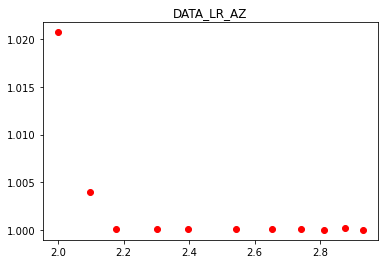

In [7]:
par_rock = 1e8
datapoints_AZ = np.zeros(11)
lrs_AZ = np.array([100, 125, 150, 200, 250, 350, 450, 550, 650, 750, 850])

for i, lr in enumerate(lrs_AZ):
    temp = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate=lr, discretization_init=False, timed=True)
    datapoints_AZ[i] = np.sum(temp.simulated_volume) / par_rock


logar = np.log10(lrs_AZ)
print(logar,datapoints_AZ)

plt.title('DATA_LR_AZ')
plt.plot(logar,datapoints_AZ,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 1.1942 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 2.7637 seconds
Counting interfaces...  Done in 0.0283 seconds
Correcting interface arrays for consistency...
too few Q -3
too much P 1
too much K 1
too much B 1
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.2019 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 0.5550 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 0.9720 seconds
Counting interfaces...  Done in 0.0098 seconds
Correcting interface arrays for consistency...
too m

Text(0.5, 1.0, 'DATA_LR_CA_EW')

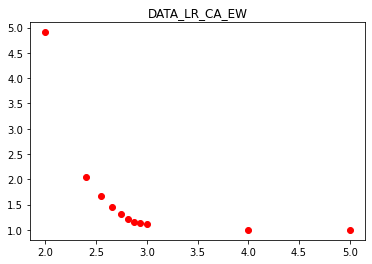

In [8]:
par_rock = 1e8
datapoints_CA_EW = np.zeros(11)
lrs_CA_EW = np.array([100, 1000, 10000, 100000, 250, 350, 450, 550, 650, 750, 850])

for i, lr in enumerate(lrs_CA_EW):
    temp = SedGen(minerals, par_rock, modal_mineralogy[1], csds_CA_EW_means, csds_CA_EW_stds, learning_rate=lr, discretization_init=False, timed=True)
    datapoints_CA_EW[i] = np.sum(temp.simulated_volume) / par_rock


logar = np.log10(lrs_CA_EW)
print(logar,datapoints_CA_EW)

plt.title('DATA_LR_CA_EW')
plt.plot(logar,datapoints_CA_EW,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 1.1395 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 2.5923 seconds
Counting interfaces...  Done in 0.0300 seconds
Correcting interface arrays for consistency...
too much Q 5
all good P 0
too much K 1
too few B -3
too few O -2
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.1782 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 0.1743 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 0.4839 seconds
Counting interfaces...  Done in 0.0049 seconds
Correcting interface arrays for consistency...
too m

Text(0.5, 1.0, 'DATA_LR_CA_NS')

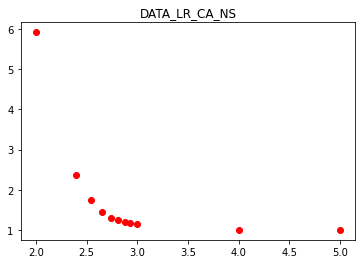

In [9]:
par_rock = 1e8
datapoints_CA_NS = np.zeros(11)
lrs_CA_NS = np.array([100, 1000, 10000, 100000, 250, 350, 450, 550, 650, 750, 850])

for i, lr in enumerate(lrs_CA_NS):
    temp = SedGen(minerals, par_rock, modal_mineralogy[2], csds_CA_NS_means, csds_CA_NS_stds, learning_rate=lr, discretization_init=False, timed=True)
    datapoints_CA_NS[i] = np.sum(temp.simulated_volume) / par_rock


logar = np.log10(lrs_CA_NS)
print(logar, datapoints_CA_NS)

plt.title('DATA_LR_CA_NS')
plt.plot(logar,datapoints_CA_NS,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 3.1569 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 7.1000 seconds
Counting interfaces...  Done in 0.0765 seconds
Correcting interface arrays for consistency...
too much Q 13
too few P -3
all good K 0
too few B -1
too few O -2
too few A -7
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.4521 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 3.1067 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 7.3753 seconds
Counting interfaces...  Done in 0.0815 seconds
Correcting interface arrays for consistency...
too 

Text(0.5, 1.0, 'DATA_LR_GR')

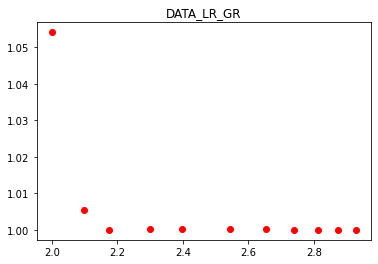

In [10]:
par_rock = 1e8
datapoints_GR = np.zeros(11)
lrs_GR = np.array([100, 125, 150, 200, 250, 350, 450, 550, 650, 750, 850])

for i, lr in enumerate(lrs_GR):
    temp = SedGen(minerals, par_rock, modal_mineralogy[3], csds_GR_means, csds_GR_stds, learning_rate=lr, discretization_init=False, timed=True)
    datapoints_GR[i] = np.sum(temp.simulated_volume) / par_rock


logar = np.log10(lrs_GR)
print(logar, datapoints_GR)

plt.title('DATA_LR_GR')
plt.plot(logar,datapoints_GR,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 1.8769 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 4.0456 seconds
Counting interfaces...  Done in 0.0412 seconds
Correcting interface arrays for consistency...
too much Q 12
too few P -4
too few K -4
too few B -2
too few O -1
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.2576 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 1.7007 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 3.8951 seconds
Counting interfaces...  Done in 0.0382 seconds
Correcting interface arrays for consistency...
too 

Text(0.5, 1.0, 'DATA_LR_MT')

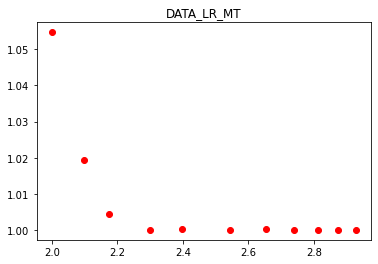

In [11]:
par_rock = 1e8
datapoints_MT = np.zeros(11)
lrs_MT = np.array([100, 125, 150, 200, 250, 350, 450, 550, 650, 750, 850])

for i, lr in enumerate(lrs_MT):
    temp = SedGen(minerals, par_rock, modal_mineralogy[4], csds_MT_means, csds_MT_stds, learning_rate=lr, discretization_init=False, timed=True)
    datapoints_MT[i] = np.sum(temp.simulated_volume) / par_rock


logar = np.log10(lrs_MT)
print(logar, datapoints_MT)

plt.title('DATA_LR_MT')
plt.plot(logar,datapoints_MT,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 11.3340 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 24.2275 seconds
Counting interfaces...  Done in 0.2719 seconds
Correcting interface arrays for consistency...
too much Q 2
too much P 1
too much K 1
all good B 0
too few O -1
too few A -3
Initializing crystal size array... |Q|P|K|B|O|A| Done in 1.7352 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 7.7456 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 16.6910 seconds
Counting interfaces...  Done in 0.1839 seconds
Correcting interface arrays for consistency...
to

Text(0.5, 1.0, 'DATA_LR_WA')

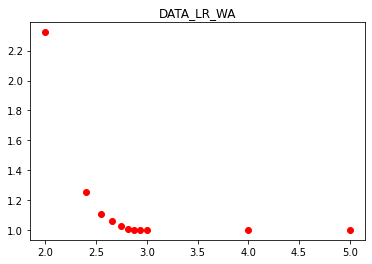

In [15]:
par_rock = 1e9
datapoints_WA = np.zeros(11)
lrs_WA = np.array([100, 1000, 10000, 100000, 250, 350, 450, 550, 650, 750, 850])

for i, lr in enumerate(lrs_WA):
    temp = SedGen(minerals, par_rock, modal_mineralogy[5], csds_WA_means, csds_WA_stds, learning_rate=lr, discretization_init=False, timed=True)
    datapoints_WA[i] = np.sum(temp.simulated_volume) / par_rock


logar = np.log10(lrs_WA)
print(logar, datapoints_WA)

plt.title('DATA_LR_WA')
plt.plot(logar,datapoints_WA,'ro')
